# Implementation of the SPT Model - Testing

Modifications: Johnny Esteves\ Author: Allen Pinjic - Created on June 14th, 2022

In [1]:
from astropy.io.fits import getdata
from astropy.table import Table
from astropy.cosmology import WMAP9 as cosmo
from colossus.cosmology import cosmology
from colossus.lss import mass_function
cosmology.setCosmology('WMAP9')

In [2]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import pylab as plt
import pymc3 as pm
import aesara
import matplotlib.font_manager
import scipy.stats
import scipy.optimize
import seaborn as sns
import math

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
%matplotlib inline

## Creating the Model via Simulated Data

In [4]:
sigma_chisi, sigma_lbd = 0.16, 0.169
rho = 0.79
Nclusters = 100000

# Cluster is defined as Mass (M) and redshift (z)

In [5]:
mfakes = 10**(np.random.uniform(14,15.2, size=Nclusters))
zfakes = np.random.uniform(0.1, 1.3, size=Nclusters)
# No "10^" for zfakes?
# Creating Nclusters number of fake mass 
# and redshift samples that are uniformly distributed

In [6]:
def _halo_mass_function(M, z):
    return mass_function.massFunction(M, z, mdef = '500c', model = 'bocquet16')
halo_mass_function = np.vectorize(_halo_mass_function)

def E(z):
    # The Hubble constant at the value of z
    Hz = cosmo.H(z).value
    # The Hubble constant at z=0
    H0 = cosmo.H(0).value
    return (Hz/H0)

p_halos = halo_mass_function(mfakes, zfakes)

indices_halos = np.random.choice(Nclusters, size = 1000, p = (p_halos/(np.sum(p_halos))))
# size = Nclusters/100 or 100,000/100 = 1000

In [7]:
# The creation of the fake samples for redshift and mass
# by chnaging the distribution from uniform to parabolic
zsims = zfakes[indices_halos]
msims = mfakes[indices_halos]

In [8]:
M0 = 3e14
Ez0 = E(0)

theta = [5.24, 1.534, 0.465, 0.161, 76.9, 1.02, 0.29, 0.16, 0.8]

A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
A_sze, B_sze, C_sze, scatter_sze = theta[:4]
rho = theta[-1]

def ln_zeta_given_M(theta_sze,M,z):
    return (np.log(A_sze) + (B_sze)*np.log(M/M0) + (C_sze)*(np.log(E(z)/Ez0)))

def ln_lbd_given_M(theta_lambda,M,z):
    return (np.log(A_lambda) + (B_lambda)*np.log(M/M0) + (C_lambda)*(np.log(E(z)/Ez0)))

ln_zeta_true = ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze], msims, zsims)
ln_lambda_true = ln_lbd_given_M([A_lambda, B_lambda, C_lambda, scatter_lambda], msims, zsims)

#mean = [lbd_true, zeta_true]

In [9]:
# To correlate them:
Cov = np.matrix(([sigma_lbd**2, rho*sigma_lbd*sigma_chisi], [rho*sigma_lbd*sigma_chisi, sigma_lbd**2]))

# for a given cluster: msims, msims

ln_lambda, ln_zeta = [], []
for i in range(len(ln_lambda_true)):
    ln_lambdai, ln_zetai = np.random.multivariate_normal([ln_lambda_true[i],ln_zeta_true[i]],cov=Cov)
    ln_lambda.append(ln_lambdai)
    ln_zeta.append(ln_zetai)
    
# Final dataset --> (zsims, msims, ln_lambda, ln_zeta, ln_lambda_true, ln_zeta_true)

In [10]:
# Changes the size of the graph and font
from scipy.optimize import curve_fit

sns.set_theme(style="darkgrid")
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

Combination of Slope and Y-Intercept: [1.01289577 4.40211651]
Slope: 1.012895773505024
Y-Intercept: 4.4021165124320705


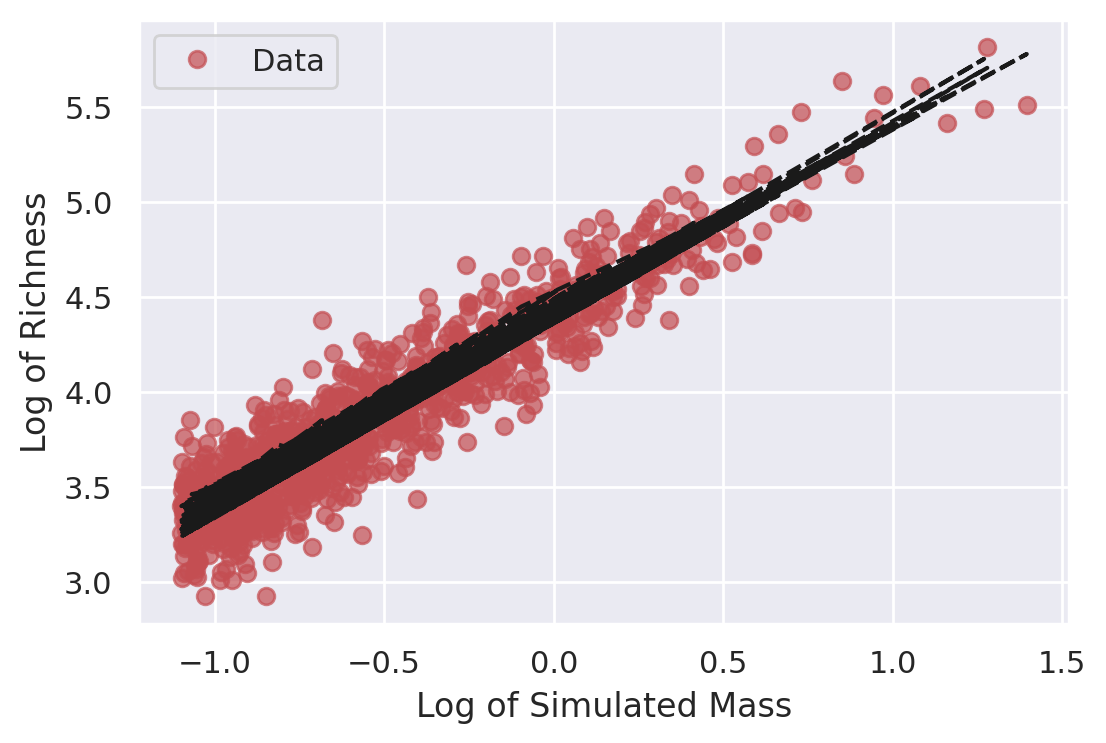

In [11]:
log_msims = np.log(msims/M0)

x1 = log_msims
y1 = ln_lambda

f=lambda x,a,b: a*x + b
fit=curve_fit(f, x1, y1)
xsmooth=np.linspace(np.min(x1), np.max(x1), 1000)
plt.plot(x1,y1,'ro',label='Data', alpha = 0.7)
#plt.plot(xsmooth,f(xsmooth,*fit[0]),'b-',linewidth=2,label='Logarithmic Fit')
plt.xlabel('Log of Simulated Mass')
plt.ylabel('Log of Richness')
plt.legend()

# Unlike the 1-D plot above (simple straight line), this is a vector that
# will create a slope which matches the log value from the previously
# calculated log of lambda based on the true parameter values
# found in (Grandis et al. 2021)

# Meant to compare with the simple 1-D plot above and display
# whether the simulated data is following the trend set by the real parameter values

plt.plot(x1, ln_lambda_true, 'k--', label='Truth')

print('Combination of Slope and Y-Intercept:', fit[0])
print('Slope:', fit[0][0])
print('Y-Intercept:', fit[0][1])

Combination of Slope and Y-Intercept: [1.52383503 1.75756015]
Slope: 1.5238350277742294
Y-Intercept: 1.7575601457894765


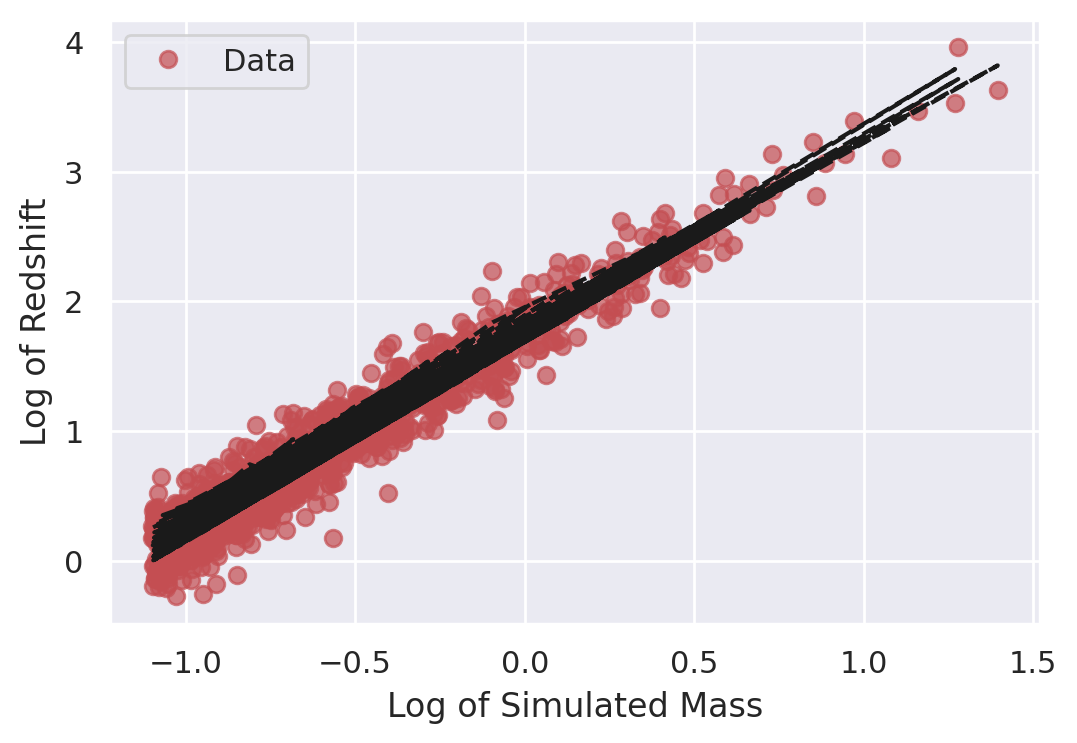

In [12]:
x2 = log_msims
y2 = ln_zeta

f=lambda x,a,b: a*x + b
fit=curve_fit(f, x2, y2)
xsmooth=np.linspace(np.min(x2), np.max(x2), 1000)
plt.plot(x2,y2,'ro',label='Data', alpha = 0.7)
#plt.plot(xsmooth,f(xsmooth,*fit[0]),'b-',linewidth=2,label='Logarithmic Fit')
plt.xlabel('Log of Simulated Mass')
plt.ylabel('Log of Redshift')
plt.legend()


# Unlike the 1-D plot above (simple straight line), this is a vector that
# will create a slope which matches the log value from the previously
# calculated log of zeta based on the true parameter values
# found in (Grandis et al. 2021)

# Meant to compare with the simple 1-D plot above and display
# whether the simulated data is following the trend set by the real parameter values

plt.plot(x1, ln_zeta_true, 'k--', label='Truth')

print('Combination of Slope and Y-Intercept:', fit[0])
print('Slope:', fit[0][0])
print('Y-Intercept:', fit[0][1])

## Testing the Model using the SPT Sample

Unlike Model V2 or V2.1, this model assumes the value of the mass is known in order to more quickly obtain and analyze any given results

In [ ]:
fname = '../data_set/sptecs_catalog_oct919.fits'

data = Table(getdata(fname))
data[:2]

In [ ]:
sz_signal = np.array(data['XI'])
lambda_chisq = np.array(data['LAMBDA_CHISQ'])
lambda_chisqE = np.array(data['LAMBDA_CHISQ_E'])
redshift = np.array(data['REDSHIFT'])
M500 = np.array(data['M500']*1e14)

In [ ]:
plt.hist(np.log10(data['M500'][lambda_chisq>20]*1e14))

In [ ]:
## def _halo_mass_function(M, z):
##    return mass_function.massFunction(M, z, mdef = '500c', model = 'bocquet16')
## halo_mass_function = np.vectorize(_halo_mass_function)

def E(z):
    # The Hubble constant at the value of z
    Hz = cosmo.H(z).value
    # The Hubble constant at z=0
    H0 = cosmo.H(0).value
    return (Hz/H0)

In [ ]:
M0 = 3e14
Ez0 = E(0)

#Insert the priors on the SZE scaling relation parameters that identify with SZE,
# along with a value for the mass (M) and redshift (z)
## References Equation 2
def ln_zeta_given_M(theta_sze,M,z):
    A_sze, B_sze, C_sze, scatter_sze = theta_sze
    return (np.log(A_sze) + (B_sze)*np.log(M/M0) + (C_sze)*(np.log(E(z)/Ez0)))

#Insert the priors on the SZE scaling relation parameters that identify with LAMBDA, 
# along with a value for the mass (M) and redshift (z)
# Identified with the 
# References Equation 3
def ln_lbd_given_M(theta_lambda,M,z):
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta_lambda
    return (np.log(A_lambda) + (B_lambda)*np.log(M/M0) + (C_lambda)*(np.log(E(z)/Ez0)))

#Insert the value of the mean and standard deviation as the two parameters
# to find the log of the variance in a normal distribution
def logNormal_variance(mu,std):
    return (np.exp(std**2)-1)*np.exp(2*mu+std**2)
# the linear relation lnLbd and lnZeta are logNormal
# the scatter of a logNormal is different from a normal distribution

In [ ]:
# set up integration vectors
# mvec = np.logspace(13.8, 15.5, 75)
# lbdvec = np.linspace(3,1.2*np.max(lambda_chisq),150)
lbdvec = np.linspace(3,1.2*np.max(lambda_chisq),29)
# zetavec = np.linspace(1,1.1*np.max(sz_signal),75)
zetavec = np.linspace(1,1.1*np.max(sz_signal),24)


# lbdvec = np.exp(np.arange(np.log(5),np.log(1.2*np.max(lambda_chisq)),0.032))
# zetavec = np.exp(np.arange(np.log(1),np.log(1.1*np.max(sz_signal)),0.045))

print('Vector size')
## print(mvec.size)
print(lbdvec.size)
print(zetavec.size)

In [ ]:
zvec = np.linspace(np.min(redshift), np.max(redshift), 100)
## zzv, mm = np.meshgrid(zvec, mvec)
zzv= np.meshgrid(zvec)
from scipy import interpolate
## halo_mass_function2 = interpolate.interp1d(zvec, halo_mass_function(mm, zzv), kind='cubic')

In [ ]:
def slice_array(y,alpha=1e-2):
    cy = np.cumsum(y/np.sum(y),axis=0)
    ilo,iup = np.interp([alpha,1-alpha],cy,np.arange(len(y))).astype(int)+(0,2)
    return ilo, iup

In [ ]:
def prob_chisi(zeta, chisi, eps=1e-12):
    res = np.exp(-(chisi-np.sqrt(zeta**2+2))**2/2.)/np.sqrt(2*np.pi)
    return res#np.where(res<eps,0.,res)

def gaussian(x,mu,std):
    return np.exp(-(x-mu)**2/std**2/2.)/np.sqrt(2*np.pi*std**2)

def prob_lbd_hat(lbd, lbd_hat, lbd_error, eps=1e-12):
    res = gaussian(lbd, lbd_hat, lbd_error)
    return res#np.where(res<eps,0.,res)

In [ ]:
from scipy.integrate import simps

# given: mvec, lbdvec and zetavec

zz, ll = np.meshgrid(zetavec, lbdvec, indexing='ij')

def log_likelihood_vec2(theta, x, y, yerr, eps=1e-9):
    # defining variables
    lbd_hat, chisi = y[0], y[1]
    lbd_err = yerr
    mass, z = x[0], x[1]
    probs = []
    for lbd_hat_i, lbd_err_i, chisi_i, m_i, z_i in zip(lbd_hat, lbd_err,chisi, mass, z):
        probs.append(_log_likelihood2(theta, lbd_hat_i, lbd_err_i, chisi_i, m_i, z_i))    
    p = np.array(probs)/np.sum(probs)
    log_p = np.log(p)
    log_p = np.where(np.isnan(log_p), -np.inf, log_p)
    return np.sum(log_p)

In [ ]:
def _log_likelihood2(theta, lbd_hat_i, lbd_err_i, chisi_i, m_i, z_i):
    # unfolding theta
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
    A_sze, B_sze, C_sze, scatter_sze = theta[:4]
    rho = theta[-1]
    
    # calling predictions;
    ln_lbd_pred = ln_lbd_given_M([A_lambda, B_lambda, C_lambda, scatter_lambda], m_i , z_i)
    ln_zeta_pred= ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze], m_i ,z_i)
    ## halo_mass_func = halo_mass_function2(z_i)
    
    # error probabilities
    p_chisi = prob_chisi(zetavec, chisi_i)
    p_lbd_hat = prob_lbd_hat(lbdvec, lbd_hat_i, lbd_err_i)
    
    # take only significant p_lbd_hat values
    llo, lup = slice_array(p_lbd_hat,alpha=1e-4)
    clo, cup = slice_array(p_chisi,alpha=1e-4)
    
    ## hmf = np.tile(halo_mass_func, (int(lup-llo), int(cup-clo), 1)).T
    ln_lbd_pred = np.tile(ln_lbd_pred, (int(lup-llo), int(cup-clo), 1)).T
    ln_zeta_pred = np.tile(ln_zeta_pred, (int(lup-llo), int(cup-clo), 1)).T
    
    # compute dn_dlbd_dzeta_integrand
    # Now p_lbd_zeta instead of p_total_m = compute_dn_dlbd_dzeta_vec2
    
    p_lbd_zeta = compute_dn_dlbd_dzeta_vec2(lbd_hat_i, lbd_err_i, chisi_i,
                                           scatter_lambda, scatter_sze, rho,
                                           ll[clo:cup,llo:lup],zz[clo:cup,llo:lup],
                                           ln_lbd_pred, ln_zeta_pred)
    
    # integrate over zeta
    p_chisi = np.tile(p_chisi[clo:cup], (int(lup-llo), 1)).T
    product = p_lbd_zeta.dot(p_chisi)
    p_lbd = np.trapz(product, x=zetavec[clo:cup], axis=0)

    # integrate over lambda
    p = np.trapz(p_lbd*p_lbd_hat, x=lbdvec[llo:lup], axis=0)
    return p#np.log(p)

In [ ]:
def compute_dn_dlbd_dzeta_vec2(lbd_hat_i, lbd_err_i, chisi_i, scatter_lambda, scatter_sze, rho,
                               lvec, zvec, ln_lbd_pred, ln_zeta_pred, eps = 1e-9):
    # converting std to normal distribution
    #s_zeta = logNormal_variance(ln_zeta_pred, scatter_sze)
    #s_lambda = logNormal_variance(ln_lbd_pred, scatter_lambda)
    s_zeta = np.where(scatter_sze<=eps, -np.inf, 1/scatter_sze)
    s_lambda = np.where(scatter_lambda<=eps, -np.inf, 1/scatter_lambda)
    
    cov = ((scatter_lambda)**(2))*((scatter_sze)**(2))*(1-(rho**2))
    additional_cov = (-0.5)*np.log((np.pi*cov**2))
    
    # avoid error messages
    rho_inv = (1-rho**2)
    rho_inv = np.where(rho_inv<=eps, -np.inf, 1/rho_inv)
    
    
    # defining standardized variables
    lbd_std = (np.log(lvec) - (ln_lbd_pred))*s_lambda
    zeta_std = (np.log(zvec)- (ln_zeta_pred))*s_zeta
    np.seterr(invalid='ignore')

    # lbd_likelihood
    lp_lbd  = (-rho_inv*lbd_std**2)/2

    # zeta likelihood
    lp_zeta = (-rho_inv*zeta_std**2)/2

    # corr likelihod
    lp_corr = rho*rho_inv*lbd_std*zeta_std

    lp_total_m = lp_lbd + lp_zeta + lp_corr + additional_cov
    
    p_total_m = (np.exp(lp_total_m))/(lvec*zvec)
    
    return p_total_m


In [ ]:
Np = 100
ix = np.where(lambda_chisq>5)[0] # take 100 points

z = redshift[ix]
chisi = sz_signal[ix]
lbd_hat = lambda_chisq[ix]
lbd_err = lambda_chisqE[ix]

# for a given cluster, i.e. a vector (lbd_hat_i, chisi_i, z_i)
# ix = np.arange(len(lambda_chisq))[lambda_chisq>0][np.argmin(sz_signal[lambda_chisq>0])]
ix = np.arange(len(lambda_chisq))[lambda_chisq>0][np.argmax(lambda_chisq[lambda_chisq>0])]

lbd_hat_i = lambda_chisq[ix]
lbd_err_i = lambda_chisqE[ix]
chisi_i = sz_signal[ix]
z_i = redshift[ix]

In [ ]:
eps  =1e-9
lbd  = lbd_hat[0]
zeta = chisi[0]

theta = [5.24, 1.534, 0.465, 0.161, 76.9, 1.02, 0.29, 0.16, 0.8]

In [ ]:
from __future__ import print_function, division

import os
import sys
import numpy as np
import emcee

SZ_Priors = {'A_sze':[5.24, 0.85], 'B_sze':[1.534, 0.100],'C_sze':[0.465, 0.407],
             'scatter_sze':[0.161, 0.080]}

sz_theta_values = ['A_sze', 'B_sze', 'C_sze', 'scatter_sze']

Lambda_Priors = {'A_lambda':[76.9, 8.2], 'B_lambda':[1.020, 0.080],'C_lambda':[0.23, 0.16],
             'scatter_lambda':[0.23, 0.16]}

lambda_theta_values = ['A_lambda', 'B_lambda', 'C_lambda', 'scatter_lambda']

rho = theta[-1]
scatter_sze = theta[3]
scatter_lambda = theta[7]


def set_gaussian_prior(param, mu, sigma):
    return -0.5*((param - mu)/sigma)**2

# Setting SZE priors
def set_prior_sze(theta_values):
    lp = 0.
    rhomin = 0.
    rhomax = 1.
    
    for i, prior_name in enumerate(['A_sze', 'B_sze', 'C_sze', 'scatter_sze']):
        mean, error = SZ_Priors[prior_name]
        param = theta_values[i]
        lp += set_gaussian_prior(param, mean, error)
    
    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range 
    lp = 0. if (scatter_sze > 0) else -np.inf
    return lp

# Setting Lambda priors
def set_prior_lambda(theta_values):
    lp = 0.
    rhomin = 0.
    rhomax = 1.
    
    for i, prior_name in enumerate(['A_lambda', 'B_lambda', 'C_lambda', 'scatter_lambda']):
        mean, error = Lambda_Priors[prior_name]
        param = theta_values[i]
        lp += set_gaussian_prior(param, mean, error)
       
    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range 
    lp = 0. if (scatter_lambda > 0) else -np.inf
    return lp

def logprior(theta):
    lp = 0
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
    A_sze, B_sze, C_sze, scatter_sze = theta[:4]
    rho = theta[-1]
    
    lp_lambda = set_prior_lambda([A_lambda, B_lambda, C_lambda, scatter_lambda])
    lp_sze = set_prior_sze([A_sze, B_sze, C_sze, scatter_sze])
    
    lp = 0. if ((rho > 0) and (rho < 1)) else -np.inf
    return lp + lp_lambda + lp_sze

In [ ]:
set_prior_sze([5.24, 1.534, 0.465, 0.161])

In [ ]:
y = np.vstack([lbd_hat,chisi])
yerr = lbd_err
x = np.vstack([M500,redshift])

def logposterior(theta, x, y, yerr):
    lp = logprior(theta)
    
    # if the prior is not finite return a probability of zero (log probability of -inf)
    if not np.isfinite(lp):
        return -np.inf
    
    # return the likeihood times the prior (log likelihood plus the log prior)
    return lp + log_likelihood_vec2(theta, x, y, yerr, eps=1e-9)

In [ ]:
Nburnin = 500 # number of burn-in samples
Nsamples = 5000 # number of final posterior samples
walkers = 32
ndims = len(theta)
guess = (np.array(theta)[:, np.newaxis]*(1.+0.01*np.random.normal(size=(ndims,walkers)))).T

# set additional args for the posterior (the data, the noise std. dev., and the abscissa)
argslist = (x, y, yerr)

In [ ]:
from multiprocessing import Pool
import time

with Pool(processes = 16) as pool:
    sampler = emcee.EnsembleSampler(walkers, ndims, logposterior,args=argslist, pool=pool)
    start = time.time()
    sampler.run_mcmc(guess, Nsamples+Nburnin, progress=True)
    end = time.time()
    multi_time = end - start
    serial_time = (1.5)*(3600)
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    print("{0:.1f} times faster than serial".format(serial_time / multi_time))

In [ ]:
# set up the sampler
sampler = emcee.EnsembleSampler(walkers, ndims, logposterior, args=argslist)

# pass the initial samples and total number of samples required
sampler.run_mcmc(guess, Nsamples+Nburnin);

# extract the samples (removing the burn-in)
postsamples = sampler.chain[:, Nburnin:, :].reshape((-1, ndims))

In [ ]:
A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
A_sze, B_sze, C_sze, scatter_sze = theta[:4]
rho = theta[-1]

try:
    import matplotlib as mpl
    mpl.use("Agg") # force Matplotlib backend to Agg
    import corner # import corner.py
except ImportError:
    sys.exit(1)

print('Number of posterior samples is {}'.format(postsamples.shape[0]))

fig = corner.corner(postsamples, labels=[r"Aλ", r"Bλ", r"Cλ", r"Scatter", r"A_SZE", r"B_SZE", r"C_SZE", r"Scatter_SZE", "ρ"]
                    , truths=[A_lambda, B_lambda, C_lambda, scatter_lambda,
                              A_sze, B_sze, C_sze, scatter_sze, rho])